In [49]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import pprint

from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import euclidean
from scipy.stats import ttest_ind
from scipy import stats

# **DATA PREPROCESSING**

In [2]:
df = pd.read_csv('QVI_data.csv')
df.head()

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264834 entries, 0 to 264833
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   LYLTY_CARD_NBR    264834 non-null  int64  
 1   DATE              264834 non-null  object 
 2   STORE_NBR         264834 non-null  int64  
 3   TXN_ID            264834 non-null  int64  
 4   PROD_NBR          264834 non-null  int64  
 5   PROD_NAME         264834 non-null  object 
 6   PROD_QTY          264834 non-null  int64  
 7   TOT_SALES         264834 non-null  float64
 8   PACK_SIZE         264834 non-null  int64  
 9   BRAND             264834 non-null  object 
 10  LIFESTAGE         264834 non-null  object 
 11  PREMIUM_CUSTOMER  264834 non-null  object 
dtypes: float64(1), int64(6), object(5)
memory usage: 24.2+ MB


In [4]:
df.describe()

,LYLTY_CARD_NBR,STORE_NBR,TXN_ID,PROD_NBR,PROD_QTY,TOT_SALES,PACK_SIZE
count,2.648340e+05,264834.000000,2.648340e+05,264834.000000,264834.000000,264834.000000,264834.000000
mean,1.355488e+05,135.079423,1.351576e+05,56.583554,1.905813,7.299346,182.425512
std,8.057990e+04,76.784063,7.813292e+04,32.826444,0.343436,2.527241,64.325148
min,1.000000e+03,1.000000,1.000000e+00,1.000000,1.000000,1.500000,70.000000
25%,7.002100e+04,70.000000,6.760050e+04,28.000000,2.000000,5.400000,150.000000
50%,1.303570e+05,130.000000,1.351365e+05,56.000000,2.000000,7.400000,170.000000
75%,2.030940e+05,203.000000,2.026998e+05,85.000000,2.000000,9.200000,175.000000
max,2.373711e+06,272.000000,2.415841e+06,114.000000,5.000000,29.500000,380.000000


In [5]:
df["DATE"] = pd.to_datetime(df["DATE"])
df["DATE"].dtype

dtype('<M8[ns]')

In [6]:
df["MONTH_YEAR"] = df["DATE"].dt.to_period("M")
df.head()

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,MONTH_YEAR
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium,2018-10
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream,2018-09
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget,2019-03
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget,2019-03
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream,2018-11


In [7]:
# aggregate per store-month
metrics = df.groupby(['STORE_NBR','MONTH_YEAR']).agg(
    monthly_sales=('TOT_SALES','sum'), # total sales per store-month
    monthly_customers=('LYLTY_CARD_NBR','nunique'), # unique customers per store-month
    monthly_txns=('TXN_ID','nunique'), # total transactions per store-month
    monthly_units=('PROD_QTY','sum') # total units sold per store-month
).reset_index()

# derived metrics
metrics['txn_per_customer'] = metrics['monthly_txns'] / metrics['monthly_customers']
metrics['avg_spend_per_customer'] = metrics['monthly_sales'] / metrics['monthly_customers']
metrics['avg_units_per_customer'] = metrics['monthly_units'] / metrics['monthly_customers']


In [8]:
# Trial period from Feb 2019 to April 2019. Therefore we need to filter for the pre-trial period from July 2018 to Jan 2019
pre_trial = metrics[
    (metrics['MONTH_YEAR'] >= '2018-07') & 
    (metrics['MONTH_YEAR'] <= '2019-01')
]

In [9]:
# count months per store
store_month_counts = pre_trial.groupby('STORE_NBR')['MONTH_YEAR'].nunique()

# filter stores that have exactly 7 months in pre-trial
valid_stores = store_month_counts[store_month_counts == 7].index

pre_trial_clean = pre_trial[pre_trial['STORE_NBR'].isin(valid_stores)]

In [10]:
pre_trial_clean["STORE_NBR"].nunique()

260

In [11]:
pre_trial_clean.head()

,STORE_NBR,MONTH_YEAR,monthly_sales,monthly_customers,monthly_txns,monthly_units,txn_per_customer,avg_spend_per_customer,avg_units_per_customer
0,1,2018-07,206.9,49,52,62,1.061224,4.222449,1.265306
1,1,2018-08,176.1,42,43,54,1.023810,4.192857,1.285714
2,1,2018-09,278.8,59,62,75,1.050847,4.725424,1.271186
3,1,2018-10,188.1,44,45,58,1.022727,4.275000,1.318182
4,1,2018-11,192.6,46,47,57,1.021739,4.186957,1.239130


# **SELECT CONTROL STORES**

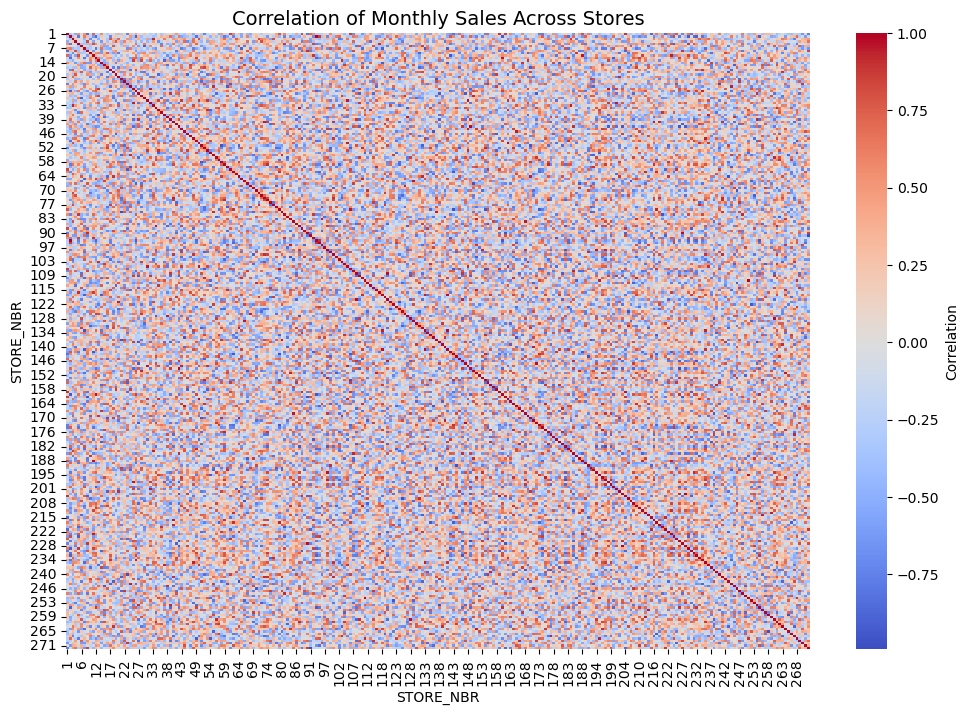

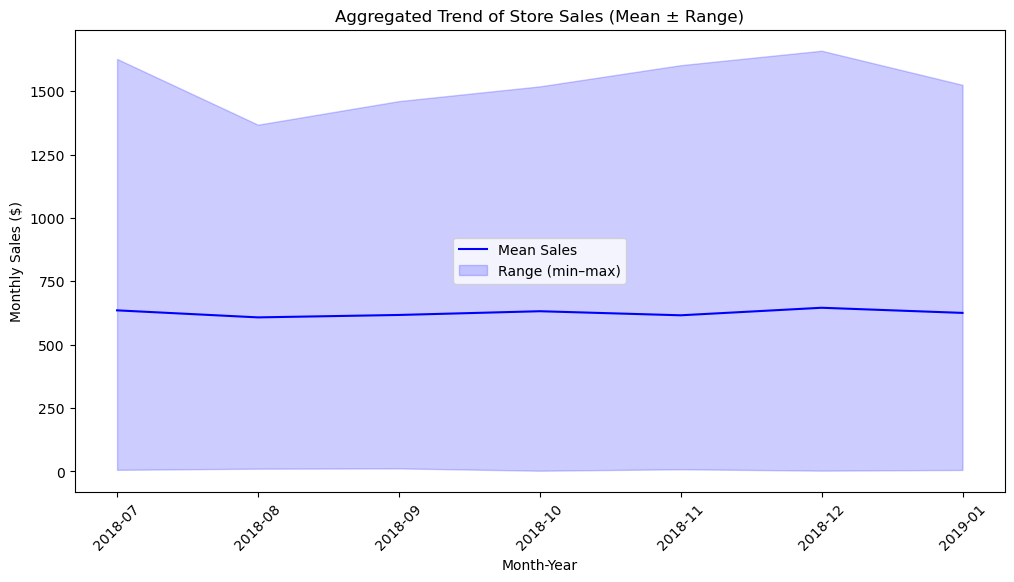

In [12]:

# Pivot to store x month matrix (monthly_sales example, but can use other metrics too)
store_month = pre_trial_clean.pivot(index='MONTH_YEAR', columns='STORE_NBR', values='monthly_sales')

# ---------------------------
# 1. Correlation heatmap
# ---------------------------
plt.figure(figsize=(12, 8))
corr = store_month.corr()
sns.heatmap(corr, cmap="coolwarm", center=0, cbar_kws={'label': 'Correlation'})
plt.title("Correlation of Monthly Sales Across Stores", fontsize=14)
plt.show()

# ---------------------------
# 2. Aggregate trend (mean ± range)
# ---------------------------
mean_series = store_month.mean(axis=1)
min_series = store_month.min(axis=1)
max_series = store_month.max(axis=1)

plt.figure(figsize=(12,6))
plt.plot(mean_series.index.astype(str), mean_series, label='Mean Sales', color='blue')
plt.fill_between(mean_series.index.astype(str), min_series, max_series, color='blue', alpha=0.2, label='Range (min–max)')
plt.xticks(rotation=45)
plt.xlabel("Month-Year")
plt.ylabel("Monthly Sales ($)")
plt.title("Aggregated Trend of Store Sales (Mean ± Range)")
plt.legend()
plt.show()

$$
Similarity Score=w_d​×Normalized Distance+w_c​×(1−Correlation)
$$

In [13]:
# Function to automate control store selection

def find_control_stores(pre_trial_df, trial_store, metrics, top_n=5, w_dist=0.5, w_corr=0.5):
    """
    Find control stores using a combined similarity score:
    Score = w_dist * normalized_distance + w_corr * (1 - correlation)
    
    Args:
        pre_trial_df (pd.DataFrame): Pre-trial metrics (store, month, metrics)
        trial_store (int): Store number of trial store
        metrics (list): List of metric columns to compare
        top_n (int): Number of top control stores to return
        w_dist, w_corr (float): Weights for distance and correlation
        
    Returns:
        pd.DataFrame: Ranked candidate control stores with distance, correlation, score
    """
    # pivot each metric into store x month matrix
    store_metrics = {}
    for m in metrics:
        store_metrics[m] = pre_trial_df.pivot(index="MONTH_YEAR", columns="STORE_NBR", values=m)
    
    # summary across metrics for distance (average over time)
    summary = pre_trial_df.groupby("STORE_NBR")[metrics].mean()
    
    # scale metrics
    scaler = StandardScaler()
    scaled = scaler.fit_transform(summary)
    summary_scaled = pd.DataFrame(scaled, index=summary.index, columns=summary.columns)
    
    # vector of trial store for distance
    trial_vec = summary_scaled.loc[trial_store].values
    
    results = []
    for store in summary_scaled.index:
        if store == trial_store:
            continue
        
        # distance (Euclidean)
        cand_vec = summary_scaled.loc[store].values
        dist = euclidean(trial_vec, cand_vec)
        
        # correlation (average across metrics)
        corrs = []
        for m in metrics:
            trial_series = store_metrics[m][trial_store]
            cand_series = store_metrics[m][store]
            corrs.append(trial_series.corr(cand_series))
        avg_corr = sum(corrs) / len(corrs)
        
        # combined score
        score = w_dist * dist + w_corr * (1 - avg_corr)
        
        results.append({
            "store": store,
            "distance": dist,
            "correlation": avg_corr,
            "score": score
        })
    
    ranked = pd.DataFrame(results).sort_values("score").reset_index(drop=True)
    return ranked.head(top_n)


#### **STORE 77**

In [14]:
# Find control store for trial store 77
metrics_to_compare = [
    "monthly_sales","monthly_customers"
]

# Top 5 control candidates for store 77
find_control_stores(pre_trial_clean, trial_store=77, metrics=metrics_to_compare, top_n=5)

,store,distance,correlation,score
0,233,0.015153,0.947066,0.034044
1,41,0.118426,0.813726,0.152350
2,167,0.150391,0.687511,0.231440
3,53,0.033020,0.567722,0.232649
4,265,0.101943,0.606610,0.247666


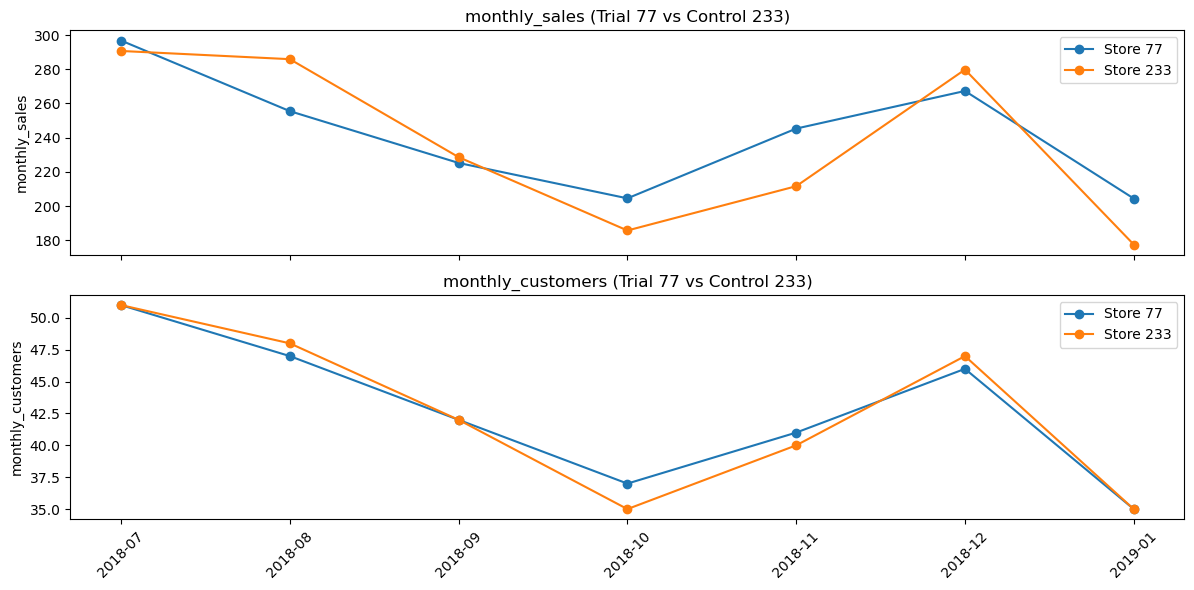

In [15]:
# Visualize trial vs control store trends to see similarity
def plot_trial_vs_control(pre_trial_df, trial_store, control_store, metrics):
    """
    Plot trial vs control store trends for selected metrics.
    
    Args:
        pre_trial_df (pd.DataFrame): pre-trial metrics dataframe
        trial_store (int): store number for trial
        control_store (int): best control store
        metrics (list): metrics to compare
    """
    # filter for the two stores
    subset = pre_trial_df[pre_trial_df['STORE_NBR'].isin([trial_store, control_store])]
    
    # plot each metric
    n_metrics = len(metrics)
    fig, axes = plt.subplots(n_metrics, 1, figsize=(12, 3*n_metrics), sharex=True)
    
    if n_metrics == 1:
        axes = [axes]  # make iterable if only 1 metric
    
    for i, m in enumerate(metrics):
        for store in [trial_store, control_store]:
            store_data = subset[subset['STORE_NBR'] == store]
            axes[i].plot(store_data['MONTH_YEAR'].astype(str), store_data[m], marker='o', label=f"Store {store}")
        
        axes[i].set_title(f"{m} (Trial {trial_store} vs Control {control_store})")
        axes[i].set_ylabel(m)
        axes[i].legend()
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Example usage
metrics_to_compare = [
    "monthly_sales","monthly_customers"
]
plot_trial_vs_control(pre_trial_clean, trial_store=77, control_store=233, metrics=metrics_to_compare)

The control store for trial store 77 is **233**

#### **STORE 86**

In [16]:
# Top 5 control candidates for store 86
find_control_stores(pre_trial_clean, trial_store=86, metrics=metrics_to_compare, top_n=5)

,store,distance,correlation,score
0,155,0.070422,0.910379,0.080022
1,109,0.045766,0.779539,0.133114
2,225,0.016201,0.675662,0.170270
3,138,0.113008,0.754782,0.179113
4,114,0.251162,0.794877,0.228142


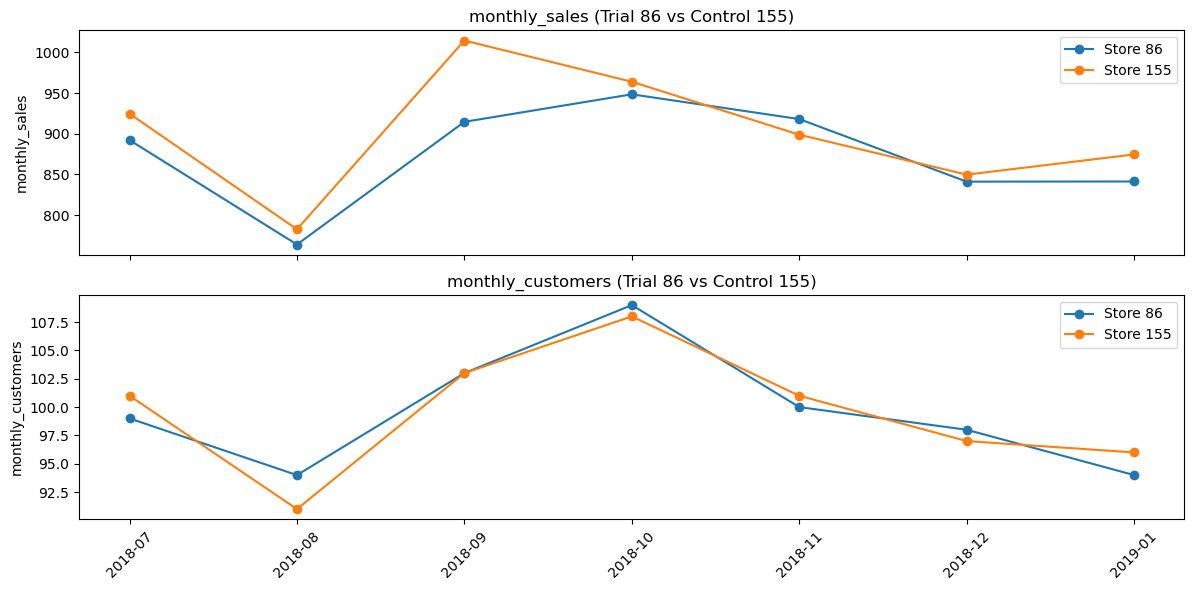

In [17]:
plot_trial_vs_control(pre_trial_clean, trial_store=86, control_store=155, metrics=metrics_to_compare)

The control store for trial store 86 is **155**

#### **STORE 88**

In [18]:
# Top 5 control candidates for store 88
find_control_stores(pre_trial_clean, trial_store=88, metrics=metrics_to_compare, top_n=5)

,store,distance,correlation,score
0,237,0.020695,0.627903,0.196396
1,203,0.223459,0.396532,0.413463
2,201,0.521763,0.502019,0.509872
3,123,0.585964,0.513843,0.536061
4,26,0.423133,0.310766,0.556184


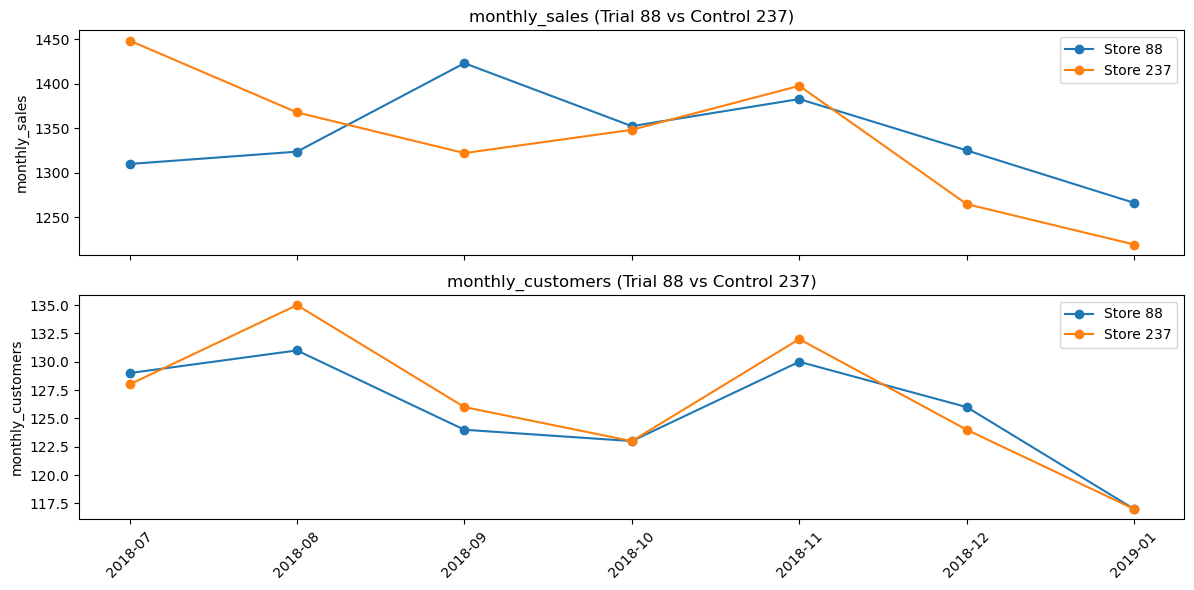

In [19]:
plot_trial_vs_control(pre_trial_clean, trial_store=88, control_store=237, metrics=metrics_to_compare)

I noticed in September 2018, the number of customers dropped for both stores, yet store 88 record an increase in monthly sales despite store 233's sales went down. I want to explore the reason behind this before choosing 237 store as the control store for trial store 88.

           count      mean       std  min  25%  50%   75%   max
STORE_NBR                                                      
88         157.0  9.063694  1.905597  6.6  7.6  8.8  10.8  20.2
233         45.0  5.080000  2.276620  1.9  3.4  4.6   7.2   9.2
   STORE_NBR  monthly_sales  customers  txns  units  txn_per_customer  \
0         88         1423.0        124   157    318          1.266129   
1        233          228.6         42    45     70          1.071429   

   avg_spend_per_customer  avg_units_per_customer  avg_spend_per_txn  
0               11.475806                2.564516           9.063694  
1                5.442857                1.666667           5.080000  


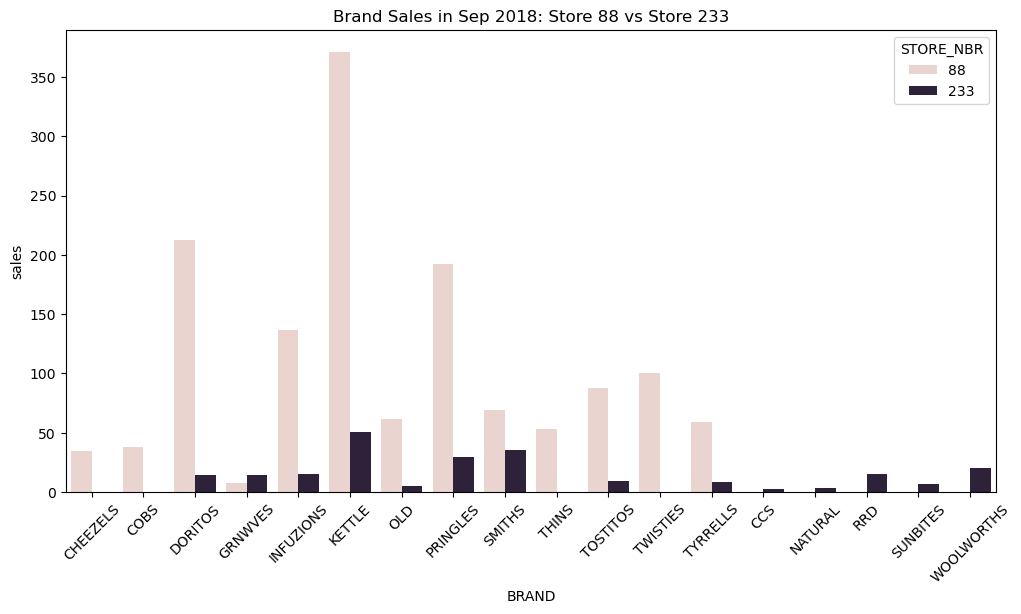

In [20]:
# Filter September 2018 for both stores
sept_data = df[(df['STORE_NBR'].isin([88, 233])) & (df['DATE'].dt.to_period('M') == '2018-09')]

# Transaction-level metrics
txn_summary = sept_data.groupby(['STORE_NBR','TXN_ID']).agg(
    txn_sales=('TOT_SALES','sum'),
    txn_units=('PROD_QTY','sum')
).reset_index()

# Compare spend per transaction
print(txn_summary.groupby('STORE_NBR')['txn_sales'].describe())

# Compare sales drivers by store
drivers = sept_data.groupby('STORE_NBR').agg(
    monthly_sales=('TOT_SALES','sum'),
    customers=('LYLTY_CARD_NBR','nunique'),
    txns=('TXN_ID','nunique'),
    units=('PROD_QTY','sum')
).reset_index()

drivers['txn_per_customer'] = drivers['txns'] / drivers['customers']
drivers['avg_spend_per_customer'] = drivers['monthly_sales'] / drivers['customers']
drivers['avg_units_per_customer'] = drivers['units'] / drivers['customers']
drivers['avg_spend_per_txn'] = drivers['monthly_sales'] / drivers['txns']

print(drivers)

# Check brand mix for Sept
brand_mix = sept_data.groupby(['STORE_NBR','BRAND']).agg(
    sales=('TOT_SALES','sum'),
    units=('PROD_QTY','sum')
).reset_index()

# Plot brand-level comparison
plt.figure(figsize=(12,6))
sns.barplot(data=brand_mix, x='BRAND', y='sales', hue='STORE_NBR')
plt.title("Brand Sales in Sep 2018: Store 88 vs Store 233")
plt.xticks(rotation=45)
plt.show()

It can be seen that store 88 and 237 are fundamentally different.

**Store 88**

- Much higher avg spend per customer (≈ 11.48 vs 5.44).

- Much higher avg spend per transaction (≈ 9.06 vs 5.08).

- Customers bought more units per customer (2.56 vs 1.67).

- Total sales are ~6× higher, despite only ~3× more customers.

**Store 233**

- Lower transaction sizes, smaller baskets.

- Customer base and sales are far lower than Store 88.

Conclusion: store 237 is not a good candidate to be a control store for 88.

In [21]:
metrics_to_compare = [
    "monthly_sales","monthly_customers",
    "txn_per_customer","avg_spend_per_customer","avg_units_per_customer"
]

# Top 5 control candidates for store 88
find_control_stores(pre_trial_clean, trial_store=88, metrics=metrics_to_compare, top_n=5)

/opt/anaconda3/envs/cusseg/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/anaconda3/envs/cusseg/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


,store,distance,correlation,score
0,237,0.166711,0.206022,0.480344
1,203,0.306625,0.271653,0.517486
2,58,0.312648,0.259937,0.526356
3,201,0.872980,0.642644,0.615168
4,226,0.452720,0.173938,0.639391


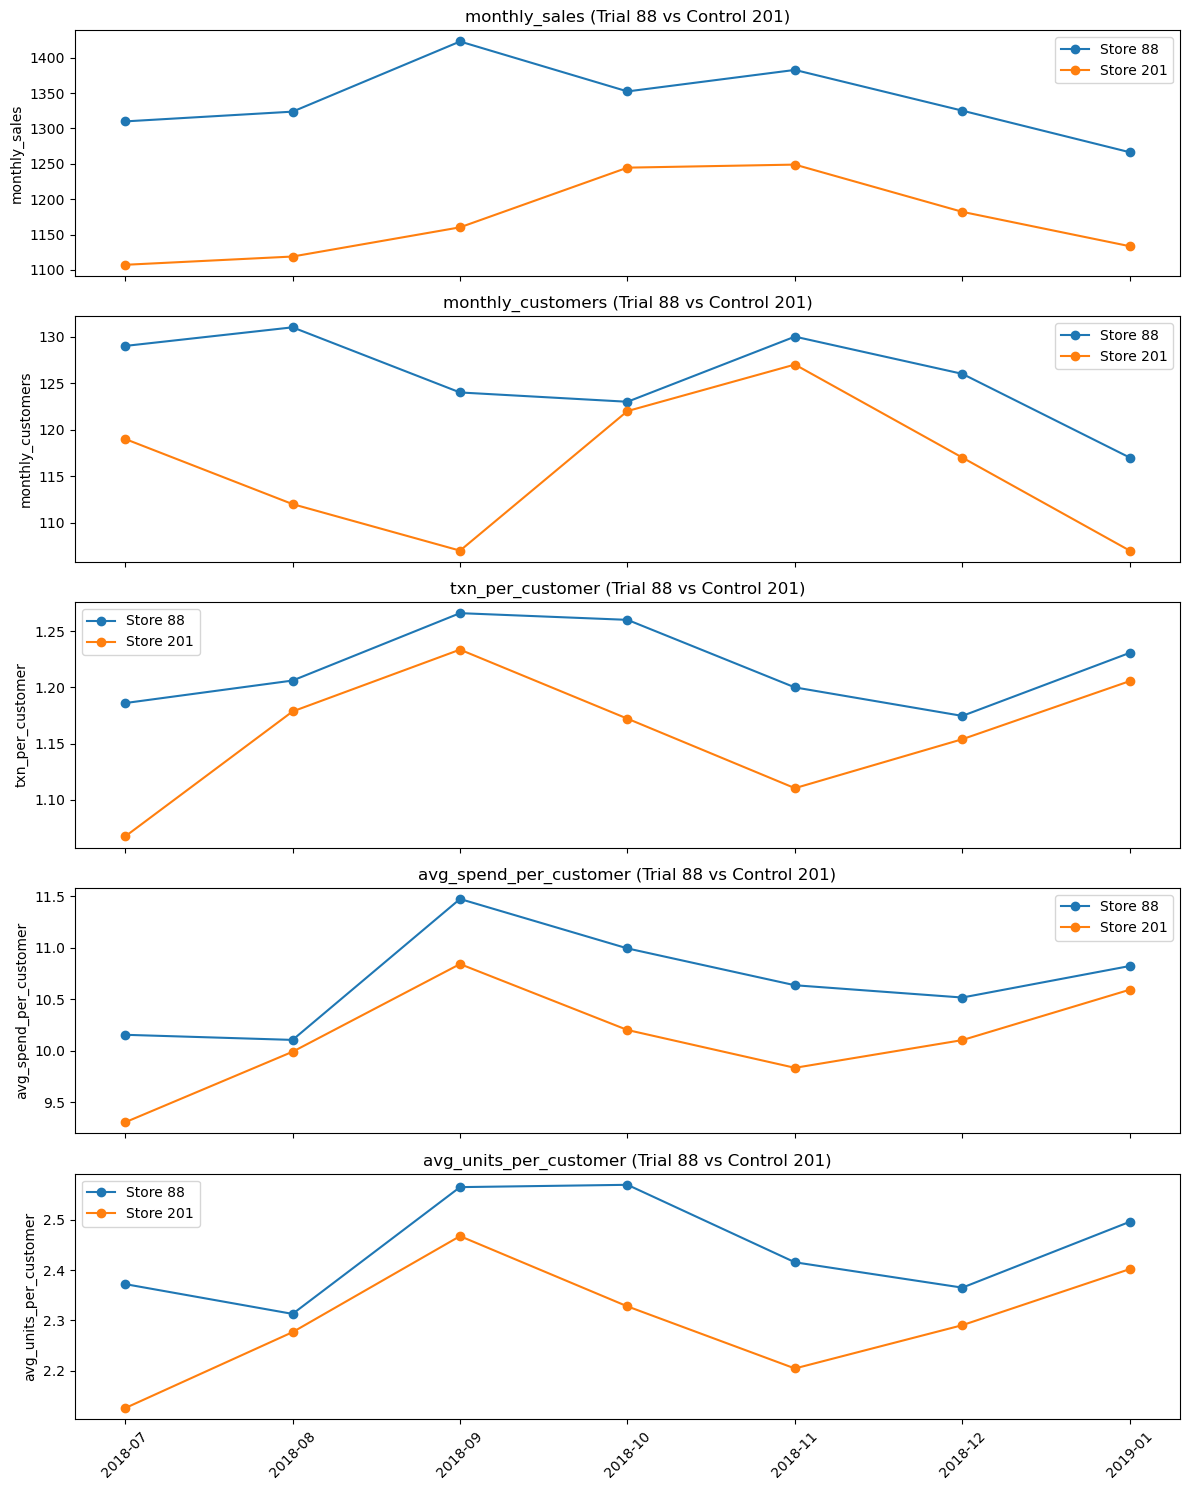

In [22]:
plot_trial_vs_control(pre_trial_clean, trial_store=88, control_store=201, metrics=metrics_to_compare)

           count      mean       std  min  25%  50%   75%   max
STORE_NBR                                                      
88         157.0  9.063694  1.905597  6.6  7.6  8.8  10.8  20.2
201        132.0  8.789394  1.815676  4.4  7.4  8.6  10.2  17.6
   STORE_NBR  monthly_sales  customers  txns  units  txn_per_customer  \
0         88         1423.0        124   157    318          1.266129   
1        201         1160.2        107   132    264          1.233645   

   avg_spend_per_customer  avg_units_per_customer  avg_spend_per_txn  
0               11.475806                2.564516           9.063694  
1               10.842991                2.467290           8.789394  


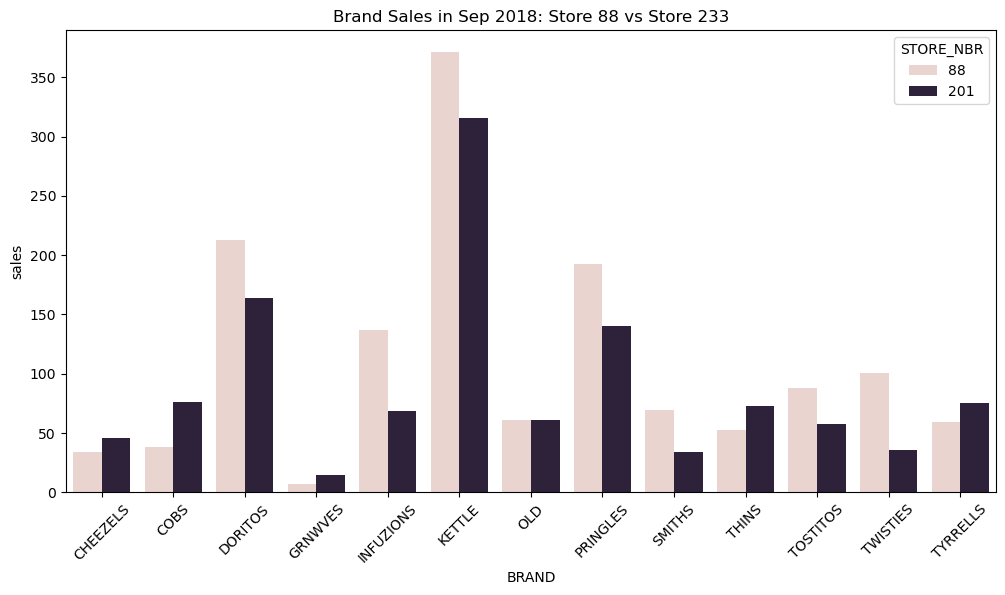

In [23]:
# Filter September 2018 for both stores
sept_data = df[(df['STORE_NBR'].isin([88, 201])) & (df['DATE'].dt.to_period('M') == '2018-09')]

# Transaction-level metrics
txn_summary = sept_data.groupby(['STORE_NBR','TXN_ID']).agg(
    txn_sales=('TOT_SALES','sum'),
    txn_units=('PROD_QTY','sum')
).reset_index()

# Compare spend per transaction
print(txn_summary.groupby('STORE_NBR')['txn_sales'].describe())

# Compare sales drivers by store
drivers = sept_data.groupby('STORE_NBR').agg(
    monthly_sales=('TOT_SALES','sum'),
    customers=('LYLTY_CARD_NBR','nunique'),
    txns=('TXN_ID','nunique'),
    units=('PROD_QTY','sum')
).reset_index()

drivers['txn_per_customer'] = drivers['txns'] / drivers['customers']
drivers['avg_spend_per_customer'] = drivers['monthly_sales'] / drivers['customers']
drivers['avg_units_per_customer'] = drivers['units'] / drivers['customers']
drivers['avg_spend_per_txn'] = drivers['monthly_sales'] / drivers['txns']

print(drivers)

# Check brand mix for Sept
brand_mix = sept_data.groupby(['STORE_NBR','BRAND']).agg(
    sales=('TOT_SALES','sum'),
    units=('PROD_QTY','sum')
).reset_index()

# Plot brand-level comparison
plt.figure(figsize=(12,6))
sns.barplot(data=brand_mix, x='BRAND', y='sales', hue='STORE_NBR')
plt.title("Brand Sales in Sep 2018: Store 88 vs Store 233")
plt.xticks(rotation=45)
plt.show()

Store 201 seems like a better control store for 88. 

#### **SUMMARY**
The selection of control stores for the stores in trial are as follow:
| Trial store      | Control store |
| ----------- | ----------- |
| 77      | 233       |
| 86   | 155        |
| 88   | 201        |

# **TRIAL ASSESSMENT**

In this section, 4 functions are desgined to automate the process of conducting significance tests for the 3 pairs of trial-control stores. 
- First function: This function is to output a df with total sales of control stores being scaled to the level total sales of pre-trial-period trial stores.
- Second function: This takes part of the output df by the first function (specifically the trial periods) and tests if trial store sales during trial months are significantly different from control.
- Third function: This takes the whole output of the first function and run a DiD test to compares percentage differences pre-trial vs in-trial.
- Forth function: This is the wrapper function to easily loop through all of the 3 pairs of stores. 

In [30]:
def prepare_comparison_df(measure_over_time, trial_store, control_store, pre_end="2019-01", trial_start="2019-02", trial_end="2019-04"):
    """
    Prepares comparison dataframe between trial and scaled control store.
    """
    df = measure_over_time.copy()
    
    # Pre-trial totals
    trial_sales_pre = df[(df['STORE_NBR'] == trial_store) & (df['MONTH_YEAR'] <= pre_end)]['TOT_SALES'].sum()
    control_sales_pre = df[(df['STORE_NBR'] == control_store) & (df['MONTH_YEAR'] <= pre_end)]['TOT_SALES'].sum()
    
    scaling_factor = trial_sales_pre / control_sales_pre
    
    # Apply scaling factor only to control
    df['scaled_control_sales'] = df.apply(
        lambda row: row['TOT_SALES'] * scaling_factor if row['STORE_NBR'] == control_store else np.nan,
        axis=1
    )
    
    # Keep only trial + control
    df = df[df['STORE_NBR'].isin([trial_store, control_store])]
    
    # Pivot to trial vs control
    trial_sales = df[df['STORE_NBR'] == trial_store][['MONTH_YEAR', 'TOT_SALES']].rename(columns={'TOT_SALES': 'trial_sales'})
    control_sales = df[df['STORE_NBR'] == control_store][['MONTH_YEAR', 'scaled_control_sales']]
    
    comparison_df = pd.merge(trial_sales, control_sales, on='MONTH_YEAR', how='inner')
    comparison_df['perc_diff'] = (comparison_df['trial_sales'] - comparison_df['scaled_control_sales']) / comparison_df['scaled_control_sales'] * 100
    
    return comparison_df, scaling_factor


In [31]:
def in_trial_test(comparison_df, trial_start="2019-02", trial_end="2019-04"):
    trial_df = comparison_df[(comparison_df['MONTH_YEAR'] >= trial_start) & (comparison_df['MONTH_YEAR'] <= trial_end)]
    
    # one-sample t-test: is perc_diff significantly different from 0?
    t_stat, p_val = stats.ttest_1samp(trial_df['perc_diff'], 0, nan_policy='omit')
    
    return {
        "mean_perc_diff": trial_df['perc_diff'].mean(),
        "t_stat": t_stat,
        "p_value": p_val
    }

In [32]:
def did_test(comparison_df, pre_end="2019-01", trial_start="2019-02", trial_end="2019-04"):
    pre_df = comparison_df[comparison_df['MONTH_YEAR'] <= pre_end]
    trial_df = comparison_df[(comparison_df['MONTH_YEAR'] >= trial_start) & (comparison_df['MONTH_YEAR'] <= trial_end)]
    
    # two-sample t-test: pre vs in-trial percentage differences
    t_stat, p_val = stats.ttest_ind(pre_df['perc_diff'], trial_df['perc_diff'], nan_policy='omit')
    
    return {
        "pre_mean": pre_df['perc_diff'].mean(),
        "trial_mean": trial_df['perc_diff'].mean(),
        "did_effect": trial_df['perc_diff'].mean() - pre_df['perc_diff'].mean(),
        "t_stat": t_stat,
        "p_value": p_val
    }

In [33]:
def analyze_trial_pair(measure_over_time, trial_store, control_store):
    comparison_df, factor = prepare_comparison_df(measure_over_time, trial_store, control_store)
    
    in_trial_result = in_trial_test(comparison_df)
    did_result = did_test(comparison_df)
    
    return {
        "trial_store": trial_store,
        "control_store": control_store,
        "scaling_factor": factor,
        "in_trial": in_trial_result,
        "diff_in_diff": did_result
    }

In [35]:
pairs = [(77, 233), (86, 155), (88, 201)]
results = [analyze_trial_pair(df, trial, control) for trial, control in pairs]

pprint.pprint(results)

[{'control_store': 233,
  'diff_in_diff': {'did_effect': np.float64(7.248740757969134),
                   'p_value': np.float64(1.9514726316179928e-07),
                   'pre_mean': np.float64(23.43387279008961),
                   't_stat': np.float64(-5.20570282638346),
                   'trial_mean': np.float64(30.682613548058743)},
  'in_trial': {'mean_perc_diff': np.float64(30.682613548058743),
               'p_value': np.float64(3.1819070066890837e-144),
               't_stat': np.float64(26.29100752906446)},
  'scaling_factor': np.float64(1.0236173032895528),
  'trial_store': 77},
 {'control_store': 155,
  'diff_in_diff': {'did_effect': np.float64(-2.0046897363292846),
                   'p_value': np.float64(1.2915824171391093e-10),
                   'pre_mean': np.float64(16.06796713127106),
                   't_stat': np.float64(6.428572230632696),
                   'trial_mean': np.float64(14.063277394941776)},
  'in_trial': {'mean_perc_diff': np.float64(14.06327739

In [ ]:
rows = []
for res in results:
    row = {
        "Trial Store": res["trial_store"],
        "Control Store": res["control_store"],
        "Scaling Factor": res["scaling_factor"],
        # in-trial
        "In-Trial Mean % Diff": res["in_trial"]["mean_perc_diff"],
        "In-Trial t-stat": res["in_trial"]["t_stat"],
        "In-Trial p-value": res["in_trial"]["p_value"],
        # diff-in-diff
        "Pre-trial Mean % Diff": res["diff_in_diff"]["pre_mean"],
        "Trial-period Mean % Diff": res["diff_in_diff"]["trial_mean"],
        "DiD Effect": res["diff_in_diff"]["did_effect"],
        "DiD t-stat": res["diff_in_diff"]["t_stat"],
        "DiD p-value": res["diff_in_diff"]["p_value"],
    }
    rows.append(row)

# create DataFrame
results_df = pd.DataFrame(rows)


   Trial Store  Control Store  Scaling Factor  In-Trial Mean % Diff  \
0           77            233          1.0236               30.6826   
1           86            155          0.9701               14.0633   
2           88            201          1.1450               -9.4356   

   In-Trial t-stat  In-Trial p-value  Pre-trial Mean % Diff  \
0          26.2910            0.0000                23.4339   
1          56.6715            0.0000                16.0680   
2        -104.6111            0.0000                -8.1689   

   Trial-period Mean % Diff  DiD Effect  DiD t-stat  DiD p-value  
0                   30.6826      7.2487     -5.2057       0.0000  
1                   14.0633     -2.0047      6.4286       0.0000  
2                   -9.4356     -1.2667      9.6017       0.0000  


In [38]:
results_df

,Trial Store,Control Store,Scaling Factor,In-Trial Mean % Diff,In-Trial t-stat,In-Trial p-value,Pre-trial Mean % Diff,Trial-period Mean % Diff,DiD Effect,DiD t-stat,DiD p-value
0,77,233,1.0236,30.6826,26.2910,0.0000,23.4339,30.6826,7.2487,-5.2057,0.0000
1,86,155,0.9701,14.0633,56.6715,0.0000,16.0680,14.0633,-2.0047,6.4286,0.0000
2,88,201,1.1450,-9.4356,-104.6111,0.0000,-8.1689,-9.4356,-1.2667,9.6017,0.0000


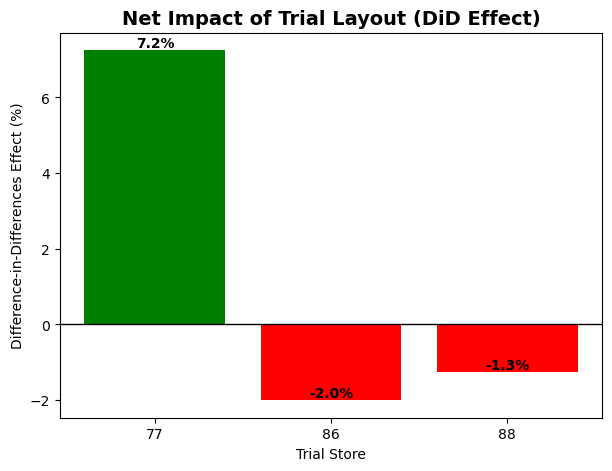

In [40]:
# Treat Trial Store as categorical labels
trial_stores = results_df["Trial Store"].astype(str)  # convert to string for clean x-axis
did_effects = results_df["DiD Effect"]

# Color coding
colors = did_effects.apply(lambda x: "green" if x > 0 else "red")

plt.figure(figsize=(7,5))
bars = plt.bar(trial_stores, did_effects, color=colors)

# Add labels
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval,
             f"{yval:.1f}%", ha="center", va="bottom", fontsize=10, weight="bold")

plt.axhline(0, color="black", linewidth=1)
plt.title("Net Impact of Trial Layout (DiD Effect)", fontsize=14, weight="bold")
plt.ylabel("Difference-in-Differences Effect (%)")
plt.xlabel("Trial Store")

plt.show()


### **INTERPRETATION OF RESULTS**

##### **TRIAL STORE: 77 AND CONTROL 233**
- In-trial mean % diff: +30.7% → Sales in the trial store were ~31% higher than its control during the trial (t = 26.29, p < 0.001 → Highly significant).
- Pre-trial difference: +23.4% → The trial store was already trending higher than its control.
- Difference-in-differences (DiD): +7.25% → After accounting for the pre-trial baseline, the net uplift due to the trial is ~7% (p < 0.001 → The uplift is statistically significant).\
✅ Interpretation: The new layout appears to have had a positive and significant effect for Store 77.

##### **TRIAL STORE: 86 AND CONTROL 155**
- In-trial mean % diff: +14.1% → Sales were higher than control during the trial (t = 56.67, p < 0.001 -> Highly siginificant).
- Pre-trial difference: +16.1% → But Store 86 was already stronger than its control before the trial.
- DiD effect: –2.0% → After adjusting for pre-trial difference, sales performance actually looks slightly worse during the trial (p < 0.001 → This negative effect is significant).\
⚠️ Interpretation: The apparent uplift is misleading — Store 86 was already outperforming control, and once we adjust for that, the trial layout does not show improvement (possibly even a small negative effect).

##### **TRIAL STORE: 88 AND CONTROL 201**
- In-trial mean % diff: –9.4% → Sales were lower than the control during the trial (t = –104.6, p < 0.001 → Highly significant).
- Pre-trial difference: –8.2% → Store 88 was already performing below its control before the trial.
- DiD effect: –1.27% → The additional drop during the trial is small but statistically significant (p < 0.001).\
❌ Interpretation: The trial layout seems to have hurt sales further in Store 88.

### **INSIGHTS**
- Store 77 → Positive, significant uplift → Good candidate for rollout.
- Store 86 → Neutral to slightly negative once adjusted → No evidence of benefit.
- Store 88 → Negative impact → Suggests trial layout is harmful here.

⚖️ Recommendation:
- Consider rolling out the new layout selectively, focusing on stores with profiles similar to Store 77.
- Stores resembling 86 and 88 should not adopt the new layout without further testing.


# **DRIVERS OF TRIAL SUCCESS**

In [45]:
metrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3169 entries, 0 to 3168
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype    
---  ------                  --------------  -----    
 0   STORE_NBR               3169 non-null   int64    
 1   MONTH_YEAR              3169 non-null   period[M]
 2   monthly_sales           3169 non-null   float64  
 3   monthly_customers       3169 non-null   int64    
 4   monthly_txns            3169 non-null   int64    
 5   monthly_units           3169 non-null   int64    
 6   txn_per_customer        3169 non-null   float64  
 7   avg_spend_per_customer  3169 non-null   float64  
 8   avg_units_per_customer  3169 non-null   float64  
dtypes: float64(4), int64(4), period[M](1)
memory usage: 222.9 KB


In [46]:
trial_store = 77
control_store = 233
trial_period = ["2019-02", "2019-04"]  # trial Feb–Apr 2019
pre_period = ["2018-07", "2019-01"]    # pre-trial July 2018–Jan 2019 

df_drivers = metrics.copy()

pre_start, pre_end = pd.Period(pre_period[0], freq='M'), pd.Period(pre_period[1], freq='M')
trial_start, trial_end = pd.Period(trial_period[0], freq='M'), pd.Period(trial_period[1], freq='M')

# Split into trial & control stores
trial_df = df_drivers[df_drivers['STORE_NBR'] == trial_store].copy()
control_df = df_drivers[df_drivers['STORE_NBR'] == control_store].copy()

# Helper to calculate averages
def summarize_period(store_df, start, end):
    mask = (store_df['MONTH_YEAR'] >= start) & (store_df['MONTH_YEAR'] <= end)
    return store_df.loc[mask, [
        'monthly_sales',
        'monthly_customers',
        'txn_per_customer',
        'avg_spend_per_customer',
        'avg_units_per_customer'
    ]].mean()

# Calculate metrics
trial_pre = summarize_period(trial_df, pre_start, pre_end)
trial_during = summarize_period(trial_df, trial_start, trial_end)

control_pre = summarize_period(control_df, pre_start, pre_end)
control_during = summarize_period(control_df, trial_start, trial_end)


In [47]:
# Calculate % change for trial vs control 
def calc_changes(pre, during):
    return ((during - pre) / pre) * 100

trial_change = calc_changes(trial_pre, trial_during)
control_change = calc_changes(control_pre, control_during)

# Net effect (DiD-style)
net_effect = trial_change - control_change

# Create summary table 
results_drivers = pd.DataFrame({
    "Metric": trial_change.index,
    "Trial Change (%)": trial_change.values,
    "Control Change (%)": control_change.values,
    "Net Effect (%)": net_effect.values
})

print("\nDriver Analysis for Store 77 vs Control 233\n")
print(results_drivers.round(2))


Driver Analysis for Store 77 vs Control 233

                   Metric  Trial Change (%)  Control Change (%)  \
0           monthly_sales            6.7100            -15.4100   
1       monthly_customers           10.8100             -9.9600   
2        txn_per_customer           -1.6500              0.3900   
3  avg_spend_per_customer           -3.8100             -5.4700   
4  avg_units_per_customer            1.6400             -4.4700   

   Net Effect (%)  
0         22.1200  
1         20.7700  
2         -2.0400  
3          1.6600  
4          6.1100  


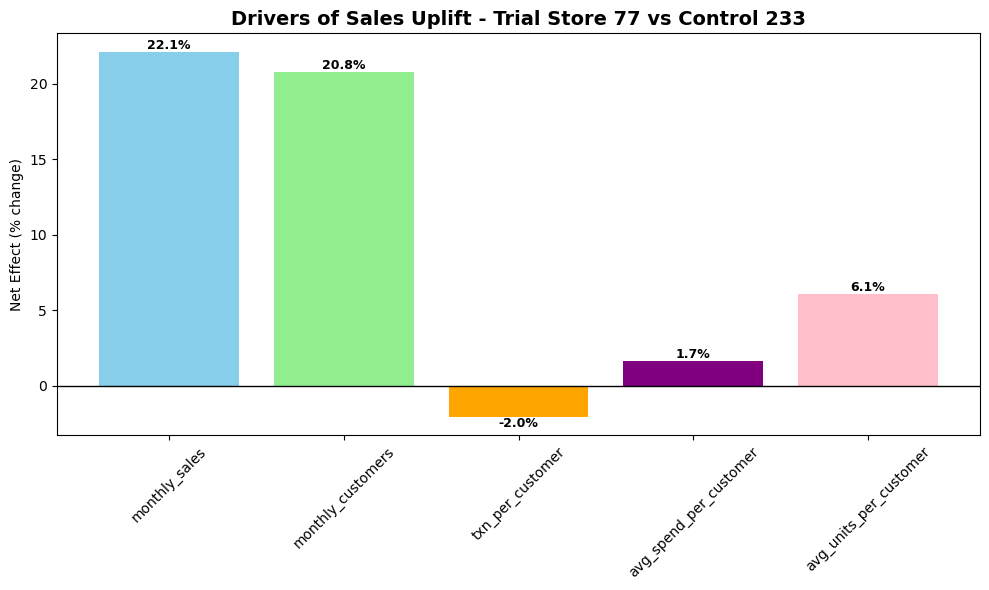

In [48]:
plt.figure(figsize=(10,6))
colors = ["skyblue", "lightgreen", "orange", "purple", "pink"]
bars = plt.bar(results_drivers["Metric"], results_drivers["Net Effect (%)"], color=colors)

# Add labels
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f"{yval:.1f}%", 
             ha="center", va="bottom" if yval >= 0 else "top", fontsize=9, weight="bold")

plt.axhline(0, color="black", linewidth=1)
plt.title("Drivers of Sales Uplift - Trial Store 77 vs Control 233", fontsize=14, weight="bold")
plt.ylabel("Net Effect (% change)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### **Overall Finding**
Sales uplift: **+22.1%** relative to the control → trial layout appears to have had a positive and meaningful impact on sales. Overall, the trial layout looks successful at Store 77.

#### **Breakdown**
##### Customer Growth (+20.8% net effect)
- The number of unique customers grew by ~10.8% in the trial store, while the control saw a decline (–9.96%).
- This is the biggest contributor to the uplift → the trial layout likely attracted new shoppers or retained more existing ones.

##### Basket Size (units per customer: +6.1% net effect)
- Trial store customers bought slightly more units per visit (+1.64%), while control customers reduced units (–4.47%).
- Suggests that the layout made chips more visible/accessible, nudging customers to add an extra pack.

##### Spend per customer (+1.66% net effect)
- Average spend/customer declined slightly in both trial and control, but the decline was less severe in the trial store.
- Implies some protection of spend levels, perhaps due to mix of premium/bigger pack sizes being picked.

##### Transaction Frequency (–2.04% net effect)
- Trial customers shopped slightly less frequently than before, unlike the control (albeit the increase in control is not much).
- This partially offsets gains, but the effect is small compared to customer growth.